# Import Module

In [ ]:
import csv
import time
import sys
import os
import random

# other library
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data 
from tqdm.notebook import tqdm 
#from torchvision import transforms
import torchvision.transforms.functional as TF

# Fix random seed

In [ ]:
SEED = 5566 # Do not modify
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Dataset Download:

In [ ]:
!gdown --id "1Ei-z7wuOosboqxlJj0V99XXyhNlc-eDs" --output "trainX.npy"
!gdown --id "11DCdXZkJqMgMZaPhgwU8WCJ_HCRW5LBw" --output "visualization_X.npy"


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Ei-z7wuOosboqxlJj0V99XXyhNlc-eDs
To: /content/trainX.npy
100% 221M/221M [00:01<00:00, 168MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=11DCdXZkJqMgMZaPhgwU8WCJ_HCRW5LBw
To: /content/visualization_X.npy
100% 15.4M/15.4M [00:00<00:00, 67.3MB/s]


# Set Hyper-parameters

In [ ]:
#TODO: Modified the hyper-parameter
NUM_EPOCH = 10 
BATCH_SIZE = 32
LATENT_DIM = 32
REDUCED_DIM = 8 
NUM_ITER = 1000
REDUCED_METHOD = 'pca' # or 'tsne'
lr = 5e-4

In [ ]:
MODEL_NAME = 'model_best.pth'
DATA_PATH = 'trainX.npy'

# Define Dataset

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, data_path):
        self.total_img = torch.from_numpy(np.load(data_path)).float()
        self.total_img = self.total_img.permute(0, 3, 1, 2)
        self.total_img = self.total_img/255
        #self.normalize = normalize
    def normalize(self, img):
        
        img = (img - img.mean())/img.std()
      
        return img
    
    def augment(self, img):
        if random.random() > 0.5:
            angle = random.randint(-20, 20)
            img = TF.rotate(img, angle)
        # if random.random() > 0.5:
        #     angle = random.randint(-20, 20)
        #     img = TF.hflip(img)      
        return img
    def __len__(self):
        return len(self.total_img)

    def __getitem__(self, index):
        img = self.total_img[index]
        img_aug = self.augment(img)
        
        img_aug = self.normalize(img_aug)
        img = self.normalize(img)
        return img_aug, img

# Define Model Architerchure

**Please finish this block to run this code!**


In [ ]:
class Net(nn.Module):
    def __init__(self, image_channels=3, latent_dim=128):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), 
            #nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(16), 
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU())
        
        # TODO: check the dimension if you modified the structure
        self.fc1 = nn.Linear(32*4*4, self.latent_dim)

        # TODO: check the dimension if you modified the structure
        self.fc2 = nn.Linear(self.latent_dim, 32*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,output_padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1,output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=3, stride=2, padding=1,output_padding=1),
            #nn.BatchNorm2d(3),
            nn.ReLU(),
           # TODO: define yout own structure
           # Hint: nn.ConvTranspose2d(...)
        )
                
    def forward(self, x):
      
        feature_map = self.encoder(x)
        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        feature_map2 = self.fc2(latent_vec)
        x_res = self.decoder(feature_map2.reshape(-1,32,4,4))
        
        return latent_vec, x_res

# Define Training Process

In [ ]:
def training(train, val, model, device, n_epoch, batch, save_name, lr):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('=== start training, parameter total:%d, trainable:%d' % (total, trainable))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                             weight_decay=1e-5)
    best_loss = 100
    for epoch in range(n_epoch):
        total_loss = 0
        
        # training set
        model.train()
        idx = 0
        for image_aug, image in tqdm(train):
            image = image.to(device, dtype=torch.float)
            image_aug = image_aug.to(device, dtype=torch.float)
            _, reconsturct = model(image_aug)
            loss = criterion(reconsturct, image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += (loss.item() / len(train))

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train)*batch, loss.item()), end='\r')
            idx += 1 
        print("\n  Training  | Loss:%.4f " % total_loss)

        # validation set
        model.eval()
        total_loss = 0
        idx = 0 
        with torch.no_grad():
            for image_aug, image in tqdm(val):
                image = image.to(device, dtype=torch.float)
                image_aug = image_aug.to(device, dtype=torch.float)
                _, reconstruct = model(image_aug)

                loss = criterion(reconstruct, image)
                total_loss += (loss.item() / len(val))
                idx += 1
            print(" Validation | Loss:%.4f " % total_loss)
        # save model
        if total_loss < best_loss:
                best_loss = total_loss
                print("saving model with loss %.4f...\n" % total_loss)
                torch.save(model.state_dict(), "%s" % save_name)

# Define Clustering Process

In [ ]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]
    
    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()
    
    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)

    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vec)
    return kmeans.labels_

# Define write function

In [ ]:
def write_output(predict_result, file_name='predict.csv'):      
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

# Main Process

In [ ]:
# build dataset
dataset = Dataset(DATA_PATH)
print(len(dataset))

# Random split
train_set_size = int(len(dataset) * 0.85)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

# set data loader
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

model = Net(latent_dim=LATENT_DIM).to(device)
print(model)
training(train_loader, valid_loader, model, device, NUM_EPOCH, BATCH_SIZE, MODEL_NAME, lr)



9000
Net(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
  )
)
=== start training, parameter total:28947, trainable:28947


  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 1 | 7648/7680] loss: 0.8717
  Training  | Loss:0.8819 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.7947 
saving model with loss 0.7947...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 2 | 7648/7680] loss: 0.8496
  Training  | Loss:0.7642 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.7434 
saving model with loss 0.7434...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 3 | 7648/7680] loss: 0.6607
  Training  | Loss:0.7184 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.7014 
saving model with loss 0.7014...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 4 | 7648/7680] loss: 0.7712
  Training  | Loss:0.6955 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6923 
saving model with loss 0.6923...



  0%|          | 0/240 [00:00<?, ?it/s]


  Training  | Loss:0.6896 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6876 
saving model with loss 0.6876...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 6 | 7648/7680] loss: 0.7207
  Training  | Loss:0.6854 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6845 
saving model with loss 0.6845...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 7 | 7648/7680] loss: 0.6284
  Training  | Loss:0.6821 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6828 
saving model with loss 0.6828...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 8 | 7648/7680] loss: 0.6505
  Training  | Loss:0.6805 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6800 
saving model with loss 0.6800...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 9 | 7648/7680] loss: 0.7043
  Training  | Loss:0.6786 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6798 
saving model with loss 0.6798...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 10 | 7648/7680] loss: 0.6722
  Training  | Loss:0.6769 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.6783 
saving model with loss 0.6783...



# Inference

In [ ]:
test_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
model.load_state_dict(torch.load(MODEL_NAME))
predicted = clustering(model, device, test_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
reverse_predicted = -(predicted-1)
write_output(predicted, 'pred.csv')

In [ ]:
def getlatent(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]
    
    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()
    
    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)

    
    return latent_vec

In [ ]:
##plot result q3
visual_dataset = Dataset('visualization_X.npy')
print(len(visual_dataset))
first_set_size = int(len(visual_dataset) * 0.5)
second_set_size = len(visual_dataset) - train_set_size

one_set = data.Subset(visual_dataset, range(0,first_set_size))
two_set = data.Subset(visual_dataset, range(first_set_size,len(visual_dataset)))
first_loader = data.DataLoader(one_set, batch_size=BATCH_SIZE, shuffle=False)
second_loader = data.DataLoader(two_set, batch_size=BATCH_SIZE, shuffle=False)

model.load_state_dict(torch.load(MODEL_NAME))



first_latent_vec = getlatent(model, device, first_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=2, perplexity=15)
second_latent_vec = getlatent(model, device, second_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=2, perplexity=15)

5000


[[-0.727193   1.4414862]
 [-0.8982367  1.2949864]
 [-0.9518088 -0.697404 ]
 ...
 [ 1.0592014 -0.161584 ]
 [ 1.5330122 -0.6508544]
 [-1.4418991  1.5602973]]


Text(0.5, 1.0, 'PCA')

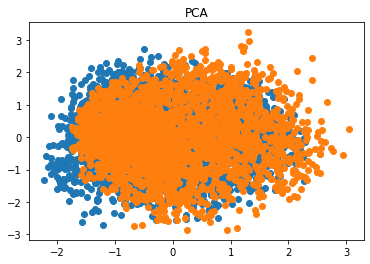

In [ ]:
print(first_latent_vec)
import matplotlib.pyplot as plt
plt.scatter(first_latent_vec[:,0], first_latent_vec[:,1])
plt.scatter(second_latent_vec[:,0], second_latent_vec[:,1])
plt.title('PCA')

In [ ]:
##plot result q2
#from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import utils as vutils
model = Net(latent_dim=LATENT_DIM).to(device)
model.load_state_dict(torch.load(MODEL_NAME))
predicted = clustering(model, device, valid_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
print(predicted)
criterion = nn.MSELoss()
model.eval()
total_loss = 0
idx = 0 
with torch.no_grad():
    for image_aug, image in tqdm(valid_loader):
        image = image.to(device, dtype=torch.float)
        print(image.shape)
        _, reconstruct = model(image)
        for i in range(24):
          loss = criterion(reconstruct[i], image[i])
          image_new = image.cpu().detach()
          reconstruct_new = reconstruct.cpu().detach()
          vutils.save_image(image_new[i],'raw'+str(i)+'.jpg')
          vutils.save_image(reconstruct_new[i],'recon'+str(i)+'.jpg')
          #transform = ToPILImage().nparray
          #newimg = transform(image[i])
          # print(image_new[i].shape)
          # ori_image = Image.fromarray(image_new[i])
          # ori_image.save('raw'+str(i)+'.jpg')
          #transform(reconstruct[i]).save('recon'+str(i)+'.jpg')
          print(loss)
        break
        

[1 1 1 ... 0 1 1]


  0%|          | 0/43 [00:00<?, ?it/s]

torch.Size([32, 3, 32, 32])
tensor(0.6743)
tensor(0.6307)
tensor(0.6717)
tensor(0.6083)
tensor(0.6328)
tensor(0.5618)
tensor(0.7834)
tensor(0.6106)
tensor(0.6427)
tensor(0.4481)
tensor(0.6984)
tensor(0.7331)
tensor(0.6862)
tensor(0.5928)
tensor(0.6583)
tensor(0.6554)
tensor(0.4791)
tensor(0.6019)
tensor(0.6921)
tensor(0.6000)
tensor(0.5650)
tensor(0.4951)
tensor(0.6829)
tensor(0.6105)
